In [5]:
pip install tqdm

Note: you may need to restart the kernel to use updated packages.


In [6]:
import torch

if torch.cuda.is_available():
    print("GPU is available: ", torch.cuda.get_device_name(0))
else:
    print("GPU is not available, using CPU instead.")

GPU is not available, using CPU instead.


In [7]:
import re
import pandas as pd
import os
import concurrent.futures

def clean_text(text):
    text = re.sub(r'\[संगीत\]', '', text)
    return re.sub(r'[^ऀ-ॿ ]', '', text).strip()

def process_subtitle_file(srt_file_path):
    subtitles = []
    with open(srt_file_path, 'r', encoding='utf-8') as file:
        content = file.readlines()
    for i in range(0, len(content), 4):
        if i + 2 < len(content):
            cleaned_line = clean_text(content[i + 2])
            if cleaned_line and len(cleaned_line.split()) > 1:
                subtitles.append([cleaned_line])
    return subtitles

def save_subtitles_to_csv(video_id, subtitles, subtitles_csv_dir):
    if subtitles:
        df_subtitles = pd.DataFrame(subtitles, columns=['Hindi'])
        csv_file_path = os.path.join(subtitles_csv_dir, f"{video_id}.csv")
        df_subtitles.to_csv(csv_file_path, index=False)

def process_file(filename, subtitles_dir, subtitles_csv_dir):
    if filename.endswith(".srt"):
        video_id = filename[:-4]
        srt_file_path = os.path.join(subtitles_dir, filename)
        subtitles = process_subtitle_file(srt_file_path)
        save_subtitles_to_csv(video_id, subtitles, subtitles_csv_dir)

def read_video_ids(file_path):
    with open(file_path, 'r') as file:
        return file.read().splitlines()

def combine_csv_files(video_ids, output_file, subtitles_csv_dir):
    csv_frames = []
    for video_id in video_ids:
        csv_path = os.path.join(subtitles_csv_dir, f"{video_id}.csv")
        if os.path.exists(csv_path):
            df = pd.read_csv(csv_path)
            csv_frames.append(df)
    combined_df = pd.concat(csv_frames)
    combined_df.drop_duplicates(inplace=True)
    combined_df.to_csv(output_file, index=False)

def parallel_process_files(files, subtitles_dir, subtitles_csv_dir):
    with concurrent.futures.ThreadPoolExecutor() as executor:
        futures = [executor.submit(process_file, filename, subtitles_dir, subtitles_csv_dir) for filename in files]
        concurrent.futures.wait(futures)

# Example usage
directories = {
    "video_ids_dir": 'video_ids',
    "subtitles_dir": 'subtitles',
    "subtitles_csv_dir": 'Subtitles_csv',
    "output_dir": 'Subtitles_csv_combined'
}

for dir_path in directories.values():
    os.makedirs(dir_path, exist_ok=True)

files = os.listdir(directories['subtitles_dir'])
parallel_process_files(files, directories['subtitles_dir'], directories['subtitles_csv_dir'])

for filename in os.listdir(directories['video_ids_dir']):
    if filename.endswith(".txt"):
        base_name = filename[:-4]
        output_filename = f"{base_name}_combined_data.csv"
        output_path = os.path.join(directories['output_dir'], output_filename)
        video_ids_path = os.path.join(directories['video_ids_dir'], filename)
        video_ids = read_video_ids(video_ids_path)
        combine_csv_files(video_ids, output_path, directories['subtitles_csv_dir'])

print("Process completed. CSV files have been combined based on video IDs and duplicates removed.")

Process completed. CSV files have been combined based on video IDs and duplicates removed.


In [3]:
import pandas as pd
import os

# Function to count words in a sentence
def count_words(sentence):
    return len(sentence.split())

# Base directory containing your CSV files
directory_path = 'Subtitles_csv_combined'

# Placeholder for combined data
combined_data = pd.DataFrame(columns=['Hindi'])

# Loop through all files in the directory
for file_name in os.listdir(directory_path):
    if file_name.endswith('.csv'):
        file_path = os.path.join(directory_path, file_name)
        
        # Read the file
        df = pd.read_csv(file_path)
        
        # Filter sentences with 5 or more words
        filtered_df = df[df['Hindi'].apply(count_words) >= 5]
        
        # Combine
        combined_data = pd.concat([combined_data, filtered_df])

# If the combined data has more than 2000 sentences, randomly select 2000
if len(combined_data) > 2000:
    combined_data = combined_data.sample(n=2000, random_state=1).reset_index(drop=True)
else:
    combined_data = combined_data.sample(frac=1, random_state=1).reset_index(drop=True)  # Shuffle if less than 2000

# Save the combined data to a new CSV file
combined_file_path = 'combined_for_translation.csv'
combined_data.to_csv(combined_file_path, index=False)

print(f'Combined file saved to {combined_file_path}')

Combined file saved to combined_for_translation.csv


In [8]:
pip install --upgrade transformers

Note: you may need to restart the kernel to use updated packages.


In [5]:
import pandas as pd
from transformers import pipeline
from concurrent.futures import ThreadPoolExecutor, as_completed

# Initialize the translation pipeline
translator = pipeline('translation', model='Helsinki-NLP/opus-mt-hi-en')

# Function to translate text
def translate_text(text):
    try:
        translation = translator(text, max_length=400)[0]['translation_text']
    except Exception as e:
        print(f"Error translating text: {e}")
        translation = ""
    return translation

# Parallel translation function
def parallel_translate(df, num_workers=5):
    texts = df['Hindi'].tolist()
    with ThreadPoolExecutor(max_workers=num_workers) as executor:
        future_to_text = {executor.submit(translate_text, text): text for text in texts}
        for future in as_completed(future_to_text):
            text = future_to_text[future]
            try:
                result = future.result()
            except Exception as exc:
                print(f'{text} generated an exception: {exc}')
            else:
                df.loc[df['Hindi'] == text, 'English'] = result
    return df

# Path to your combined CSV file
file_path = 'combined_for_translation.csv'

# Read the combined CSV file
df = pd.read_csv(file_path)

# Ensure 'English' column exists
df['English'] = ''

# Translate in parallel and update the DataFrame
df_updated = parallel_translate(df)

# Save the updated DataFrame back to the same file
df_updated.to_csv(file_path, index=False)
print(f'Translation completed and saved back to {file_path}')

Translation completed and saved back to combined_for_translation.csv


In [ ]:
df_subtitles

In [ ]:
df_subtitles.to_csv('data.csv')

In [ ]:
import random

def create_hinglish(hindi, english):
    english_words = english.split()
    hindi_words = hindi.split()
    # Decide the number of Hindi words to insert (up to 3 words or the length of the Hindi sentence)
    num_inserts = min(3, len(hindi_words))
    for _ in range(num_inserts):
        if english_words:  # Ensure there are English words left to insert into
            insert_pos = random.randint(0, len(english_words))
            hindi_word_to_insert = random.choice(hindi_words)
            english_words.insert(insert_pos, hindi_word_to_insert)
            # Optional: remove the Hindi word from future consideration (if you want each Hindi word used only once)
            hindi_words.remove(hindi_word_to_insert)
    return ' '.join(english_words)

# Apply the function to create a Hinglish column
df_subtitles['Hinglish'] = df_subtitles.apply(lambda row: create_hinglish(row['Hindi'], row['English']), axis=1)

# Displaying the DataFrame with the new Hinglish sentences
df_subtitles[['Hindi', 'English', 'Hinglish']].head()

In [ ]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

# Load English stop words
stop_words = set(stopwords.words('english'))

def create_hinglish_based_on_stopwords(english, hindi):
    words = english.split()
    stop_word_indices = [index for index, word in enumerate(words) if word.lower() in stop_words]

    if not stop_word_indices:
        # No stop words found, return the original sentence (you can decide how to handle this case)
        return english

    # Find pivot index for Hindi insertion
    pivot_index = stop_word_indices[-1] + 1  # We split the sentence after the last stop word

    english_part = " ".join(words[:pivot_index])
    hindi_part = " ".join(hindi.split()[pivot_index:])  # Corresponding Hindi split

    # Combine the English and Hindi parts
    hinglish_sentence = english_part + ' ' + hindi_part
    return hinglish_sentence

# Apply the function to create the Hinglish sentences
df_subtitles['Hinglish'] = df_subtitles.apply(lambda row: create_hinglish_based_on_stopwords(row['English'], row['Hindi']), axis=1)

df_subtitles[['English', 'Hindi', 'Hinglish']].head()

In [1]:
import pandas as pd
from transformers import pipeline, AutoTokenizer, AutoModelForSeq2SeqLM
import concurrent.futures
from concurrent.futures import ThreadPoolExecutor
from tqdm.auto import tqdm

# Define your stop words
stop_words = {"i", "me", "my", "myself", "we", "our", "ours", "ourselves", "you", "your", "yours",
    "yourself", "yourselves", "he", "him", "his", "himself", "she", "her", "hers",
    "herself", "it", "its", "itself", "they", "them", "their", "theirs", "themselves",
    "what", "which", "who", "whom", "this", "that", "these", "those", "am", "is", "are",
    "was", "were", "be", "been", "being", "have", "has", "had", "having", "do", "does",
    "did", "doing", "a", "an", "the", "and", "but", "if", "or", "because", "as", "until",
    "while", "of", "at", "by", "for", "with", "about", "against", "between", "into",
    "through", "during", "before", "after", "above", "below", "to", "from", "up", "down",
    "in", "out", "on", "off", "over", "under", "again", "further", "then", "once", "here",
    "there", "when", "where", "why", "how", "all", "any", "both", "each", "few", "more",
    "most", "other", "some", "such", "no", "nor", "not", "only", "own", "same", "so",
    "than", "too", "very", "s", "t", "can", "will", "just", "don", "should", "now", "d",
    "ll", "m", "o", "re", "ve", "y", "ain", "aren", "couldn", "didn", "doesn", "hadn",
    "hasn", "haven", "isn", "ma", "mightn", "mustn", "needn", "shan", "shouldn", "wasn",
    "weren", "won", "wouldn"}  # Customize this list as needed

def split_on_last_stopword(sentence, stop_words):
    words = sentence.split()
    last_stop_word_index = None
    for i, word in enumerate(words):
        if word.lower() in stop_words:
            last_stop_word_index = i
    if last_stop_word_index is not None and last_stop_word_index + 1 < len(words):
        return " ".join(words[:last_stop_word_index + 1]), " ".join(words[last_stop_word_index + 1:])
    else:
        return sentence, ""

def translate_to_hindi(texts):
    tokenizer = AutoTokenizer.from_pretrained("Helsinki-NLP/opus-mt-en-hi")
    model = AutoModelForSeq2SeqLM.from_pretrained("Helsinki-NLP/opus-mt-en-hi")
    translations = []
    for text in tqdm(texts, desc="Translating"):
        if text.strip():  # Check if the text is not just empty or whitespace
            inputs = tokenizer(text, return_tensors="pt", padding=True)
            outputs = model.generate(inputs["input_ids"], max_length=512, num_beams=4, early_stopping=True)
            translation = tokenizer.decode(outputs[0], skip_special_tokens=True)
            translations.append(translation)
        else:
            translations.append("")
    return translations

# Load the CSV file
df_subtitles = pd.read_csv('combined_for_translation.csv')

# Split English sentences and prepare them for translation
df_subtitles['English_Part'], df_subtitles['To_Translate'] = zip(*df_subtitles['English'].apply(lambda x: split_on_last_stopword(x, stop_words)))

batch_size = 50  # Adjust based on your system
translated_texts = []

with ThreadPoolExecutor() as executor:
    futures = []
    for i in tqdm(range(0, len(df_subtitles['To_Translate']), batch_size), desc="Processing Batches"):
        batch = df_subtitles['To_Translate'][i:i+batch_size].tolist()
        futures.append(executor.submit(translate_to_hindi, batch))

    for future in tqdm(concurrent.futures.as_completed(futures), total=len(futures), desc="Completing Translations"):
        translated_texts.extend(future.result())

# Update DataFrame with translated texts
df_subtitles['Translated'] = translated_texts

# Combine to form Hinglish sentences
df_subtitles['Hinglish'] = df_subtitles['English_Part'] + ' ' + df_subtitles['Translated']

# Save to new CSV
df_subtitles.to_csv('combined_for_translation.csv', index=False)

2024-03-25 21:34:02.452248: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Processing Batches:   0%|          | 0/40 [00:00<?, ?it/s]

Completing Translations:   0%|          | 0/40 [00:00<?, ?it/s]

Translating:   0%|          | 0/50 [00:00<?, ?it/s]

Translating:   0%|          | 0/50 [00:00<?, ?it/s]

Translating:   0%|          | 0/50 [00:00<?, ?it/s]

Translating:   0%|          | 0/50 [00:00<?, ?it/s]

Translating:   0%|          | 0/50 [00:00<?, ?it/s]

Translating:   0%|          | 0/50 [00:00<?, ?it/s]

Translating:   0%|          | 0/50 [00:00<?, ?it/s]

Translating:   0%|          | 0/50 [00:00<?, ?it/s]

Translating:   0%|          | 0/50 [00:00<?, ?it/s]

Translating:   0%|          | 0/50 [00:00<?, ?it/s]

Translating:   0%|          | 0/50 [00:00<?, ?it/s]

Translating:   0%|          | 0/50 [00:00<?, ?it/s]

Translating:   0%|          | 0/50 [00:00<?, ?it/s]

Translating:   0%|          | 0/50 [00:00<?, ?it/s]

Translating:   0%|          | 0/50 [00:00<?, ?it/s]

Translating:   0%|          | 0/50 [00:00<?, ?it/s]

Translating:   0%|          | 0/50 [00:00<?, ?it/s]

Translating:   0%|          | 0/50 [00:00<?, ?it/s]

Translating:   0%|          | 0/50 [00:00<?, ?it/s]

Translating:   0%|          | 0/50 [00:00<?, ?it/s]

Translating:   0%|          | 0/50 [00:00<?, ?it/s]

Translating:   0%|          | 0/50 [00:00<?, ?it/s]

Translating:   0%|          | 0/50 [00:00<?, ?it/s]

Translating:   0%|          | 0/50 [00:00<?, ?it/s]

Translating:   0%|          | 0/50 [00:00<?, ?it/s]

Translating:   0%|          | 0/50 [00:00<?, ?it/s]

Translating:   0%|          | 0/50 [00:00<?, ?it/s]

Translating:   0%|          | 0/50 [00:00<?, ?it/s]

Translating:   0%|          | 0/50 [00:00<?, ?it/s]

Translating:   0%|          | 0/50 [00:00<?, ?it/s]

Translating:   0%|          | 0/50 [00:00<?, ?it/s]

Translating:   0%|          | 0/50 [00:00<?, ?it/s]

Translating:   0%|          | 0/50 [00:00<?, ?it/s]

Translating:   0%|          | 0/50 [00:00<?, ?it/s]

Translating:   0%|          | 0/50 [00:00<?, ?it/s]

Translating:   0%|          | 0/50 [00:00<?, ?it/s]

Translating:   0%|          | 0/50 [00:00<?, ?it/s]

Translating:   0%|          | 0/50 [00:00<?, ?it/s]

Translating:   0%|          | 0/50 [00:00<?, ?it/s]

Translating:   0%|          | 0/50 [00:00<?, ?it/s]

In [3]:
import pandas as pd

df = pd.read_csv("combined_for_translation.csv") 

# Step 1: Filter out rows where English_Part and Hinglish are the same
df_filtered = df[df['English_Part'] != df['Hinglish']]

# Step 2: Drop unnecessary columns
df_final = df_filtered.drop(columns=['English_Part', 'To_Translate', 'Translated'])

# df_final now contains the cleaned dataset
df_final.to_csv('final_dataset.csv', index = False)

In [2]:
import pandas as pd
import numpy as np
import re
import random
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer

# NLTK downloads
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

# Preprocessing Function
def preprocess_text(text):
    text = text.lower()  # Lowercase text
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)  # Remove non-alphanumeric characters
    tokens = word_tokenize(text)  # Tokenize text
    stop_words = set(stopwords.words('english'))  # Remove stopwords
    tokens = [token for token in tokens if token not in stop_words]
    lemmatizer = WordNetLemmatizer()  # Lemmatization
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return ' '.join(tokens)

# Augmentation Function - Synonym Replacement
def get_synonyms(word):
    synonyms = set()
    for syn in wordnet.synsets(word):
        for lemma in syn.lemmas():
            synonym = lemma.name().replace("_", " ").replace("-", " ").lower()
            synonym = "".join([char for char in synonym if char in ' a-zA-Z'])
            synonyms.add(synonym)  
    if word in synonyms:
        synonyms.remove(word)
    return list(synonyms)

def augment_sentence(sentence, n_augment=1):
    tokens = word_tokenize(sentence)
    synonyms = {word: get_synonyms(word) for word in tokens}
    
    augmented_sentences = []
    for _ in range(n_augment):
        augmented_tokens = tokens.copy()
        for i, word in enumerate(tokens):
            if word in synonyms and len(synonyms[word]) > 0:
                synonym = random.choice(synonyms[word])
                augmented_tokens[i] = synonym
        augmented_sentences.append(' '.join(augmented_tokens))
    return augmented_sentences

# Load your dataset
# For demonstration, replace this with loading your actual dataset
data = pd.read_csv("final_dataset.csv")

# Apply Preprocessing
data['preprocessed_text'] = data['English'].apply(preprocess_text)

# Apply Augmentation
n_augment = 2  # Number of augmented versions to generate
augmented_texts = []
for sentence in data['preprocessed_text']:
    augmented_texts.extend(augment_sentence(sentence, n_augment=n_augment))

# Create a DataFrame for Augmented Texts
augmented_data = pd.DataFrame({'text': augmented_texts})
augmented_data['preprocessed_text'] = augmented_data['text'].apply(preprocess_text)

# Combine original and augmented datasets
combined_data = pd.concat([data[['English', 'preprocessed_text']], augmented_data]).reset_index(drop=True)

print(combined_data)

[nltk_data] Downloading package punkt to /Users/apple/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/apple/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/apple/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/apple/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


                                            English  \
0     Connect to the misleadr and three devicesages   
1                   Thanks for cursoring this video   
2                      For a time, Abraham's father   
3                 Basics Wadge Toals Torrite Expend   
4         You'll think here how Soira can do it all   
...                                             ...   
5995                                            NaN   
5996                                            NaN   
5997                                            NaN   
5998                                            NaN   
5999                                            NaN   

                       preprocessed_text         text  
0     connect misleadr three devicesages          NaN  
1                 thanks cursoring video          NaN  
2                    time abraham father          NaN  
3       basic wadge toals torrite expend          NaN  
4                      youll think soira          NaN  
...

In [9]:
data.head()

,Hindi,English,Hinglish,preprocessed_text
0,वाली डोंगल एंड तीन डिवाइसेज से कनेक्ट हो,Connect to the misleadr and three devicesages,Connect to the misleadr and निर्माण,connect misleadr three devicesages
1,धन्यवाद इस वीडियो को स्पॉन्सर करने के,Thanks for cursoring this video,Thanks for cursoring this जमा करें,thanks cursoring video
2,थे एक समय की बात है की इब्राहिम के पिता,"For a time, Abraham's father",For a घर।,time abraham father
3,बेसिक्स वाज टू ऑलवेज इवॉल्व लाइक ही सेड,Basics Wadge Toals Torrite Expend,"Basics Wadge Toals Torrite Expend लंबे समय से,...",basic wadge toals torrite expend
4,आप यहां सोचोगे कि सोरा यह सब कर कैसे पा,You'll think here how Soira can do it all,You'll think here how Soira can do it all बीमा...,youll think soira


Epoch 1/20
25/25 [==============================] - 35s 1s/step - loss: 2.7288 - accuracy: 0.8923 - val_loss: 0.6983 - val_accuracy: 0.9321
Epoch 2/20
25/25 [==============================] - 31s 1s/step - loss: 0.6639 - accuracy: 0.9296 - val_loss: 0.6169 - val_accuracy: 0.9321
Epoch 3/20
25/25 [==============================] - 34s 1s/step - loss: 0.5959 - accuracy: 0.9296 - val_loss: 0.5960 - val_accuracy: 0.9321
Epoch 4/20
25/25 [==============================] - 31s 1s/step - loss: 0.5720 - accuracy: 0.9296 - val_loss: 0.5927 - val_accuracy: 0.9321
Epoch 5/20
25/25 [==============================] - 31s 1s/step - loss: 0.5627 - accuracy: 0.9295 - val_loss: 0.5950 - val_accuracy: 0.9321
Epoch 6/20
25/25 [==============================] - 32s 1s/step - loss: 0.5564 - accuracy: 0.9295 - val_loss: 0.5979 - val_accuracy: 0.9321
Epoch 7/20
25/25 [==============================] - 31s 1s/step - loss: 0.5501 - accuracy: 0.9296 - val_loss: 0.6020 - val_accuracy: 0.9321
Epoch 8/20
25/25 [==

/Users/apple/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


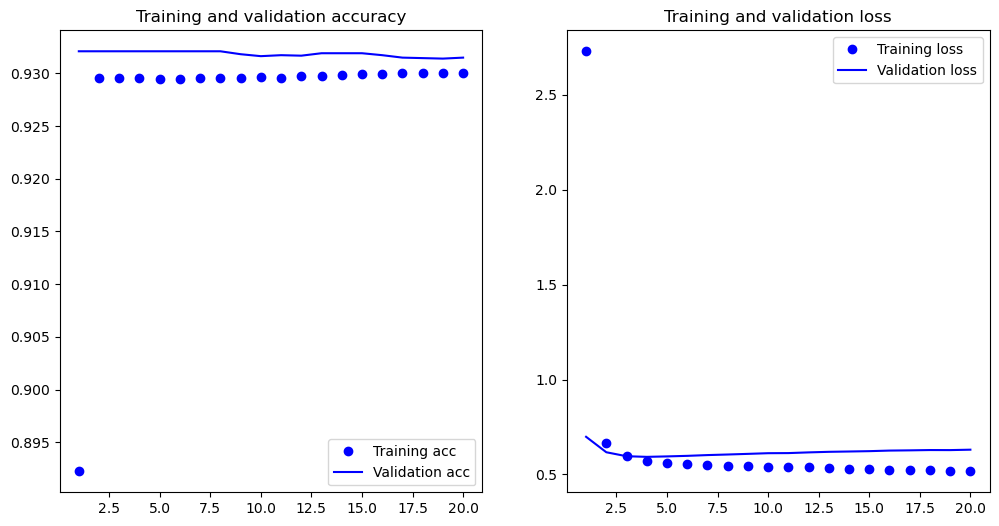

In [7]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, TimeDistributed, SpatialDropout1D, Attention, Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import numpy as np
import re

# Function to clean text data
def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^\w\s]", "", text)  # Remove punctuation
    text = re.sub(r"\d+", "", text)  # Remove numbers
    text = re.sub(r"\s+", " ", text).strip()  # Remove extra spaces
    return text

# Assuming `dataset` is your DataFrame with 'Hinglish' and 'English' columns loaded from 'final_dataset.csv'
# Clean the text data
data['Hinglish'] = data['Hinglish'].apply(clean_text)
data['preprocessed_text'] = data['preprocessed_text'].apply(clean_text)

# Use Hinglish sentences as input and English sentences as output
input_sentences = data['Hinglish']
output_sentences = data['preprocessed_text']

# Tokenization
tokenizer = Tokenizer()
tokenizer.fit_on_texts(list(input_sentences) + list(output_sentences))
input_sequences = tokenizer.texts_to_sequences(input_sentences)
output_sequences = tokenizer.texts_to_sequences(output_sentences)

# Find the maximum sequence length for padding
max_length = max(max(len(seq) for seq in input_sequences), max(len(seq) for seq in output_sequences))
vocab_size = len(tokenizer.word_index) + 1

# Padding sequences
input_padded = pad_sequences(input_sequences, maxlen=max_length, padding='post')
output_padded = pad_sequences(output_sequences, maxlen=max_length, padding='post')

# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(input_padded, output_padded, test_size=0.2, random_state=42)

# Model building with added complexity
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=512, input_length=max_length),
    SpatialDropout1D(0.2),
    Bidirectional(LSTM(256, return_sequences=True)),
    Dropout(0.5),
    TimeDistributed(Dense(vocab_size, activation='softmax'))
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


# Training the model with increased epochs
history = model.fit(X_train, y_train, batch_size=64, epochs=20, validation_data=(X_test, y_test))


# To save the model for future use
model.save('hinglish_to_english_translation_model_improved.h5')

import matplotlib.pyplot as plt

def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)
    
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    
    plt.show()

plot_training_history(history)

In [3]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, TimeDistributed, SpatialDropout1D, Attention, Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import numpy as np
import re

# Function to clean text data
def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^\w\s]", "", text)  # Remove punctuation
    text = re.sub(r"\d+", "", text)  # Remove numbers
    text = re.sub(r"\s+", " ", text).strip()  # Remove extra spaces
    return text

# Assuming `dataset` is your DataFrame with 'Hinglish' and 'English' columns loaded from 'final_dataset.csv'
# Clean the text data
data['Hinglish'] = data['Hinglish'].apply(clean_text)
data['preprocessed_text'] = data['preprocessed_text'].apply(clean_text)

# Use Hinglish sentences as input and English sentences as output
input_sentences = data['Hinglish']
output_sentences = data['preprocessed_text']

# Tokenization
tokenizer = Tokenizer()
tokenizer.fit_on_texts(list(input_sentences) + list(output_sentences))
input_sequences = tokenizer.texts_to_sequences(input_sentences)
output_sequences = tokenizer.texts_to_sequences(output_sentences)

# Find the maximum sequence length for padding
max_length = max(max(len(seq) for seq in input_sequences), max(len(seq) for seq in output_sequences))
vocab_size = len(tokenizer.word_index) + 1

# Padding sequences
input_padded = pad_sequences(input_sequences, maxlen=max_length, padding='post')
output_padded = pad_sequences(output_sequences, maxlen=max_length, padding='post')

# Early Stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='min', restore_best_weights=True)

# Reduce learning rate when a metric has stopped improving
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.001, mode='min', verbose=1)

# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(input_padded, output_padded, test_size=0.2, random_state=42)

# Model building with added complexity
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=512, input_length=max_length),
    SpatialDropout1D(0.2),
    Bidirectional(LSTM(256, return_sequences=True)),
    Dropout(0.5),
    TimeDistributed(Dense(vocab_size, activation='softmax'))
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Training the model with increased epochs
history = model.fit(
    X_train, 
    np.expand_dims(y_train, -1),  # Ensuring y_train is properly expanded for sparse_categorical_crossentropy
    batch_size=64, 
    epochs=20, 
    validation_data=(X_test, np.expand_dims(y_test, -1)),  # Same for y_test
    callbacks=[early_stopping, reduce_lr]
)

# To save the model for future use
model.save('hinglish_to_english_translation_model_improved.h5')

Epoch 1/20
25/25 [==============================] - 34s 1s/step - loss: 2.6965 - accuracy: 0.8921 - val_loss: 0.6939 - val_accuracy: 0.9321 - lr: 0.0010
Epoch 2/20
25/25 [==============================] - 33s 1s/step - loss: 0.6634 - accuracy: 0.9296 - val_loss: 0.6082 - val_accuracy: 0.9321 - lr: 0.0010
Epoch 3/20
25/25 [==============================] - 31s 1s/step - loss: 0.5911 - accuracy: 0.9296 - val_loss: 0.5945 - val_accuracy: 0.9321 - lr: 0.0010
Epoch 4/20
25/25 [==============================] - 31s 1s/step - loss: 0.5709 - accuracy: 0.9295 - val_loss: 0.5922 - val_accuracy: 0.9321 - lr: 0.0010
Epoch 5/20
25/25 [==============================] - 31s 1s/step - loss: 0.5615 - accuracy: 0.9296 - val_loss: 0.5947 - val_accuracy: 0.9321 - lr: 0.0010
Epoch 6/20
25/25 [==============================] - 31s 1s/step - loss: 0.5547 - accuracy: 0.9296 - val_loss: 0.5964 - val_accuracy: 0.9321 - lr: 0.0010
Epoch 7/20
25/25 [==============================] - 30s 1s/step - loss: 0.5494 - a

/Users/apple/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


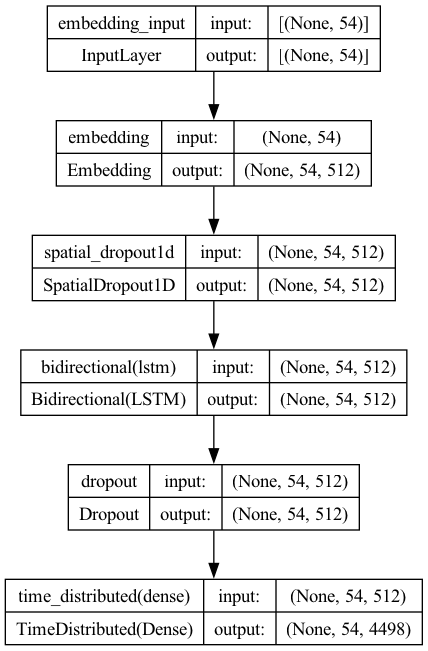

In [6]:
from tensorflow.keras.utils import plot_model

# Assuming 'model' is your trained model
plot_model(model, to_file='model_improved.png', show_shapes=True, show_layer_names=True)

In [10]:
pip install --upgrade pydot

Note: you may need to restart the kernel to use updated packages.


In [8]:
pip install graphviz

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.1/47.1 kB 2.3 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


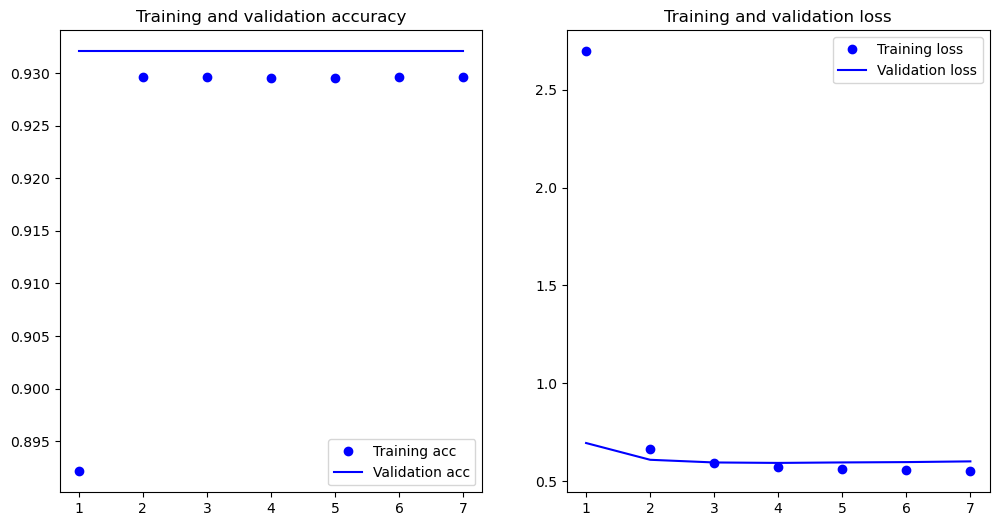

In [5]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)
    
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    
    plt.show()

plot_training_history(history)